# このnotebookについて

# 事前準備

In [20]:
import os
import json

import numpy as np

In [21]:
# 自作モジュールの読み込み
from modules.file_format.HDF5 import HDF5Reader, HDF5Writer
from modules.calculator.EoS import *

In [22]:
"""pathの設定"""
import sys
repository_root = None
for sys_path in sys.path:
    if sys_path.endswith('LAMBDA-Melting'):
        repository_root = sys_path
if repository_root is None:
    raise ValueError('repository_root is not set')

"""plot用の設定"""
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'     #数式用のフォントejavuserif" or "cm"
plt.rcParams['xtick.direction'] = 'in'      #x軸の目盛線 #内in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'      #y軸の目盛線 #内in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0     #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0     #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 14               #フォントの大きさ
plt.rcParams['axes.linewidth'] = 0.8        #軸の線幅edge linewidth。囲みの太さ
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 6)
# Arialフォントを設定
plt.rcParams.update({
    "font.family": "Arial",           # フォントをArialに設定
    "mathtext.fontset": "custom",     # カスタムフォントを指定
    "mathtext.rm": "Arial",           # 数式の通常テキスト部分
    "mathtext.it": "Arial",    # 数式のイタリック部分
    "mathtext.bf": "Arial"       # 数式の太字部分
})

# 読み込み先の設定

## 選んだRunを読み込み

In [23]:
# runの読み込み
# Run Selectorで選択したことを想定する
path_to_run_setting = os.path.join(repository_root, 'settings', 'run_selector.json')
with open(path_to_run_setting) as json_file:
    selected_run_setting = json.load(json_file)

In [24]:
selected_run_setting

{'data_root_path': '/Users/ishizawaosamu/work/MasterThesis/data',
 'current_run': 'OIbDia06_2nd',
 'path_to_run_files': '/Users/ishizawaosamu/work/MasterThesis/data/BDD/OIbDia06/2nd',
 'selected_files': {'Temperature': {'raw_radiation': 'OIbDia06_  02.spe',
   'dist': 'OIbDia06_  02_whole_m50e-2_dist.hdf'},
  'XRD': {'data': 'OIbDia06_3_00000.nxs',
   'calibration': 'pyFAI-calib2_2023_11_CeO2_MgS400_1_00000_202311.poni'}},
 'is_overwritten': True,
 'save_root_path': '/Users/ishizawaosamu/work/MasterThesis/save'}

## processed.hdfを読み込み

In [25]:
# up
up_hdf = HDF5Reader(file_path=os.path.join(
    selected_run_setting['save_root_path'],
    'processed_hdf',
    f'{selected_run_setting["current_run"]}_up_processed.hdf'
))

# down
down_hdf = HDF5Reader(file_path=os.path.join(
    selected_run_setting['save_root_path'],
    'processed_hdf',
    f'{selected_run_setting["current_run"]}_down_processed.hdf'
))

up_hdf.path_list


HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia06_2nd_up_processed.hdf
HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia06_2nd_down_processed.hdf


['entry/measured/error/T',
 'entry/measured/error/fitted_V_max/dia111',
 'entry/measured/error/fitted_V_max/kcl110',
 'entry/measured/error/fitted_V_min/dia111',
 'entry/measured/error/fitted_V_min/kcl110',
 'entry/measured/value/T',
 'entry/measured/value/fitted_V/dia111',
 'entry/measured/value/fitted_V/kcl110',
 'entry/measured/value/frame_T',
 'entry/measured/value/frame_XRD',
 'entry/measured/value/max_pos_V/dia111',
 'entry/measured/value/max_pos_V/kcl110',
 'entry/measured/value/max_position_T',
 'entry/measured/value/pattern',
 'entry/measured/value/tth',
 'entry/params/frame/T',
 'entry/params/frame/XRD',
 'entry/params/framerate/T',
 'entry/params/framerate/XRD',
 'entry/params/x-ray_wavelength',
 'entry/processed/error/P',
 'entry/processed/error/interpolated_T',
 'entry/processed/value/P',
 'entry/processed/value/interpolated_T',
 'entry/pwlf_fitting/segment_2/RSS',
 'entry/pwlf_fitting/segment_2/breakpoints_x',
 'entry/pwlf_fitting/segment_2/breakpoints_y',
 'entry/pwlf_fi

In [26]:
# データを取得
# 共通のもの
T_fps = up_hdf.find_by(query='framerate/T')
XRD_fps = up_hdf.find_by(query='framerate/XRD')
V = up_hdf.find_by(query='value/fitted_V/kcl110')

# 温度配列はそれぞれを取得
raw_T_dict = {
    'up': {
        'values': up_hdf.find_by(query='value/T'),
        'errors': up_hdf.find_by(query='error/T')
    },
    'down': {
        'values': down_hdf.find_by(query='value/T'),
        'errors': down_hdf.find_by(query='error/T')
    }
}


「framerate/T」で検索します。
	-> entry/params/framerate/T を返しました。
「framerate/XRD」で検索します。
	-> entry/params/framerate/XRD を返しました。
「value/fitted_V/kcl110」で検索します。
	-> entry/measured/value/fitted_V/kcl110 を返しました。
「value/T」で検索します。
	-> entry/measured/value/T を返しました。
「error/T」で検索します。
	-> entry/measured/error/T を返しました。
「value/T」で検索します。
	-> entry/measured/value/T を返しました。
「error/T」で検索します。
	-> entry/measured/error/T を返しました。


In [27]:
# 必要なもの
interp_measured_T_dict = {
    'up': {
        'values': None,
        'errors': None
    },
    'down': {
        'values': None,
        'errors': None
    }
}

interp_T_pm_dict = {
    'up': {
        'values': None,
        'errors': None
    },
    'down': {
        'values': None,
        'errors': None
    }
}

aimed_P_array = {
    'up': {
        'values': None,
        'errors': None
    },
    'down': {
        'values': None,
        'errors': None
    }
}

In [28]:
# 保存してないもの
T_frame_array = up_hdf.find_by(query='value/frame_T')
T_frame_num = len(T_frame_array)
T_time_array = T_frame_array / T_fps

XRD_frame_num = len(V)

「value/frame_T」で検索します。
	-> entry/measured/value/frame_T を返しました。


In [29]:
# 圧媒体の温度
T_room = 300

raw_T_pm_dict = {
    'up': {
        'values': None,
        'errors': None
    },
    'down': {
        'values': None,
        'errors': None
    }
}

for side in ['up', 'down']:
    raw_T_pm_dict[side]['values'] = (3 * raw_T_dict[side]['values'] + T_room) / 4
    raw_T_pm_dict[side]['errors'] = (raw_T_dict[side]['values'] - T_room) / 4

# 温度の形式合わせ

## メソッド定義

In [30]:
# 温度配列をXRDのframerateに合わせて補間する
from scipy.interpolate import interp1d

def interpolate_T_to_xrd(
        original_arr=None,
        T_fill=None,
        T_time_arr=T_time_array,
        T_fps=T_fps,
        T_frame_num=T_frame_num,
        xrd_fps=XRD_fps,
        xrd_frame_num=XRD_frame_num
    ):
    # T -> XRD補間後のframe数と時間配列（fpsで変換するのできっちりは合わない。足りない分はあとで足す）
    new_frame_num = int(T_frame_num * (xrd_fps / T_fps))
    new_time_arr = np.arange(new_frame_num) / xrd_fps
    # 補間はscipyに任せる
    interpolator = interp1d(T_time_arr, original_arr, kind='linear', fill_value="extrapolate")
    new_arr = interpolator(new_time_arr)
    if new_frame_num < xrd_frame_num: # 足りない分のframeを足す
        delta = xrd_frame_num - new_frame_num
        new_arr = np.r_[new_arr, np.full(delta, T_fill)]
    return new_arr


In [31]:
interp_measured_T_dict['up']['values'] = interpolate_T_to_xrd(
    original_arr=raw_T_dict['up']['values'],
    T_fill=T_room
)
for side in ['up', 'down']:
    # 測定温度
    interp_measured_T_dict[side]['values'] = interpolate_T_to_xrd(
        original_arr=raw_T_dict[side]['values'],
        T_fill=T_room
    )
    interp_measured_T_dict[side]['errors'] = interpolate_T_to_xrd(
        original_arr=raw_T_dict[side]['errors'],
        T_fill=0 # 誤差なので0埋め
    )
    # 圧媒体温度
    interp_T_pm_dict[side]['values'] = interpolate_T_to_xrd(
        original_arr=raw_T_pm_dict[side]['values'],
        T_fill=T_room
    )
    interp_T_pm_dict[side]['errors'] = interpolate_T_to_xrd(
        original_arr=raw_T_pm_dict[side]['errors'],
        T_fill=0
    )


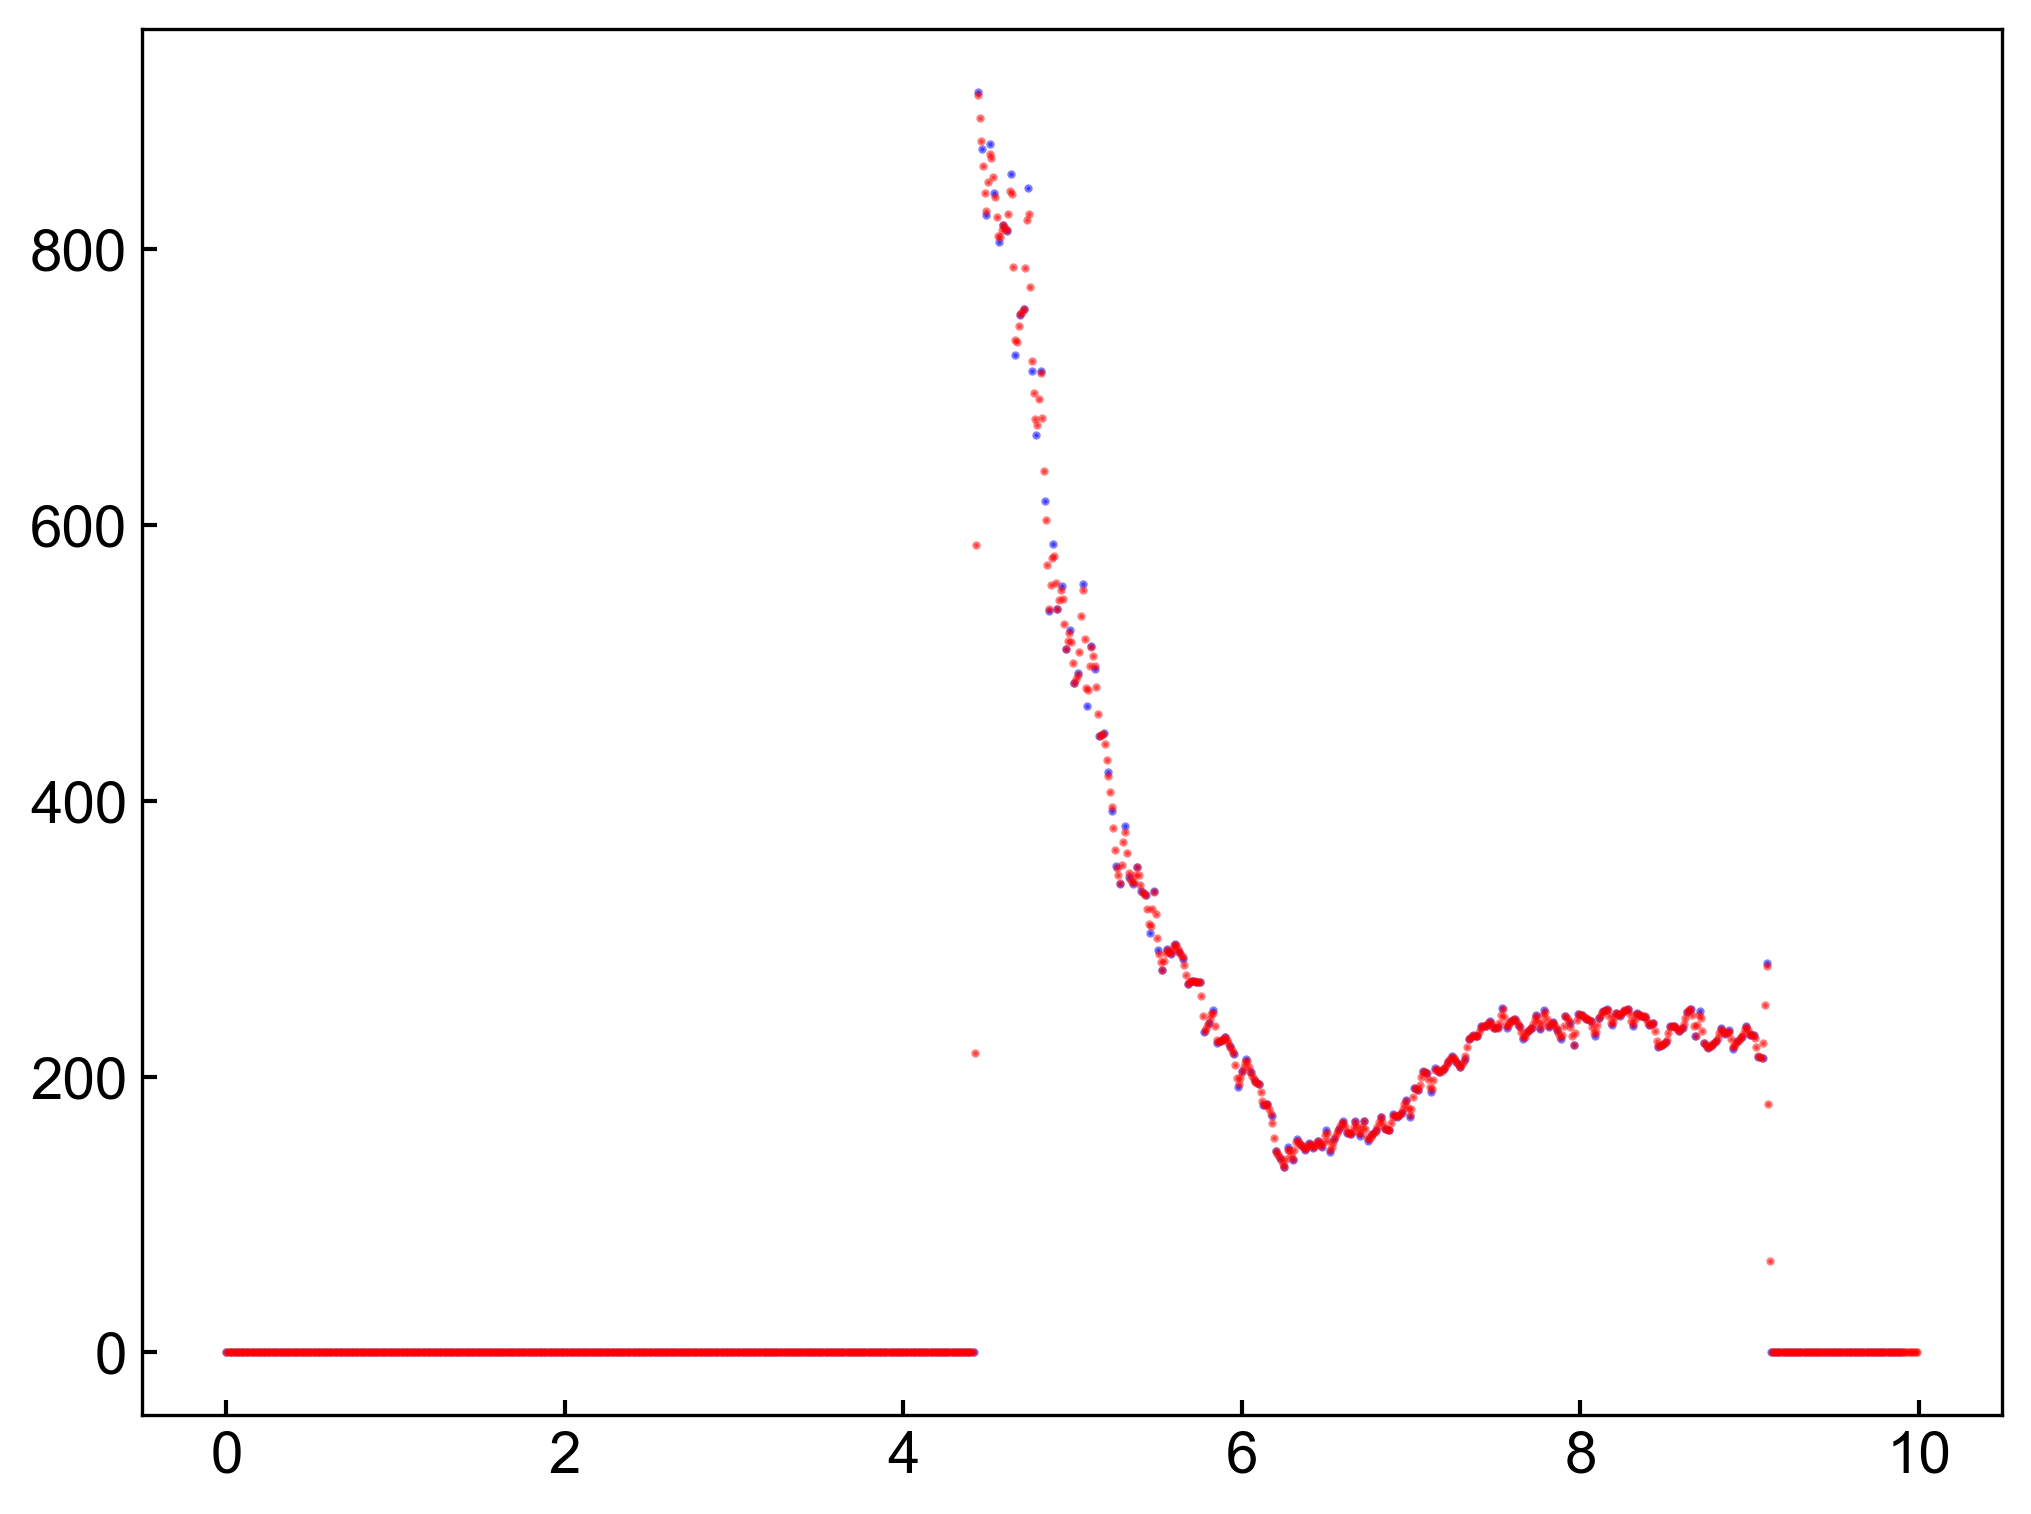

In [32]:
# 視覚化しておく
plt.scatter(np.arange(T_frame_num)/T_fps, raw_T_dict['up']['errors'], color='blue', s=1, alpha=0.5)
plt.scatter(np.arange(XRD_frame_num)/XRD_fps, interp_measured_T_dict['up']['errors'], color='red', s=1, alpha=0.5)
plt.show()
plt.close()

# 圧力計算

In [33]:
# 圧媒体温度のvalueとerrorから、Vを使って圧力のvalueとerrorを得る
for side in ['up', 'down']:
    aimed_P_array[side]['values'] = calc_P_KCl_B2(V=V, T=interp_T_pm_dict[side]['values'])
    aimed_P_array[side]['errors'] = np.abs(calc_thermal_P_KCl_B2(T=interp_T_pm_dict[side]['errors']))

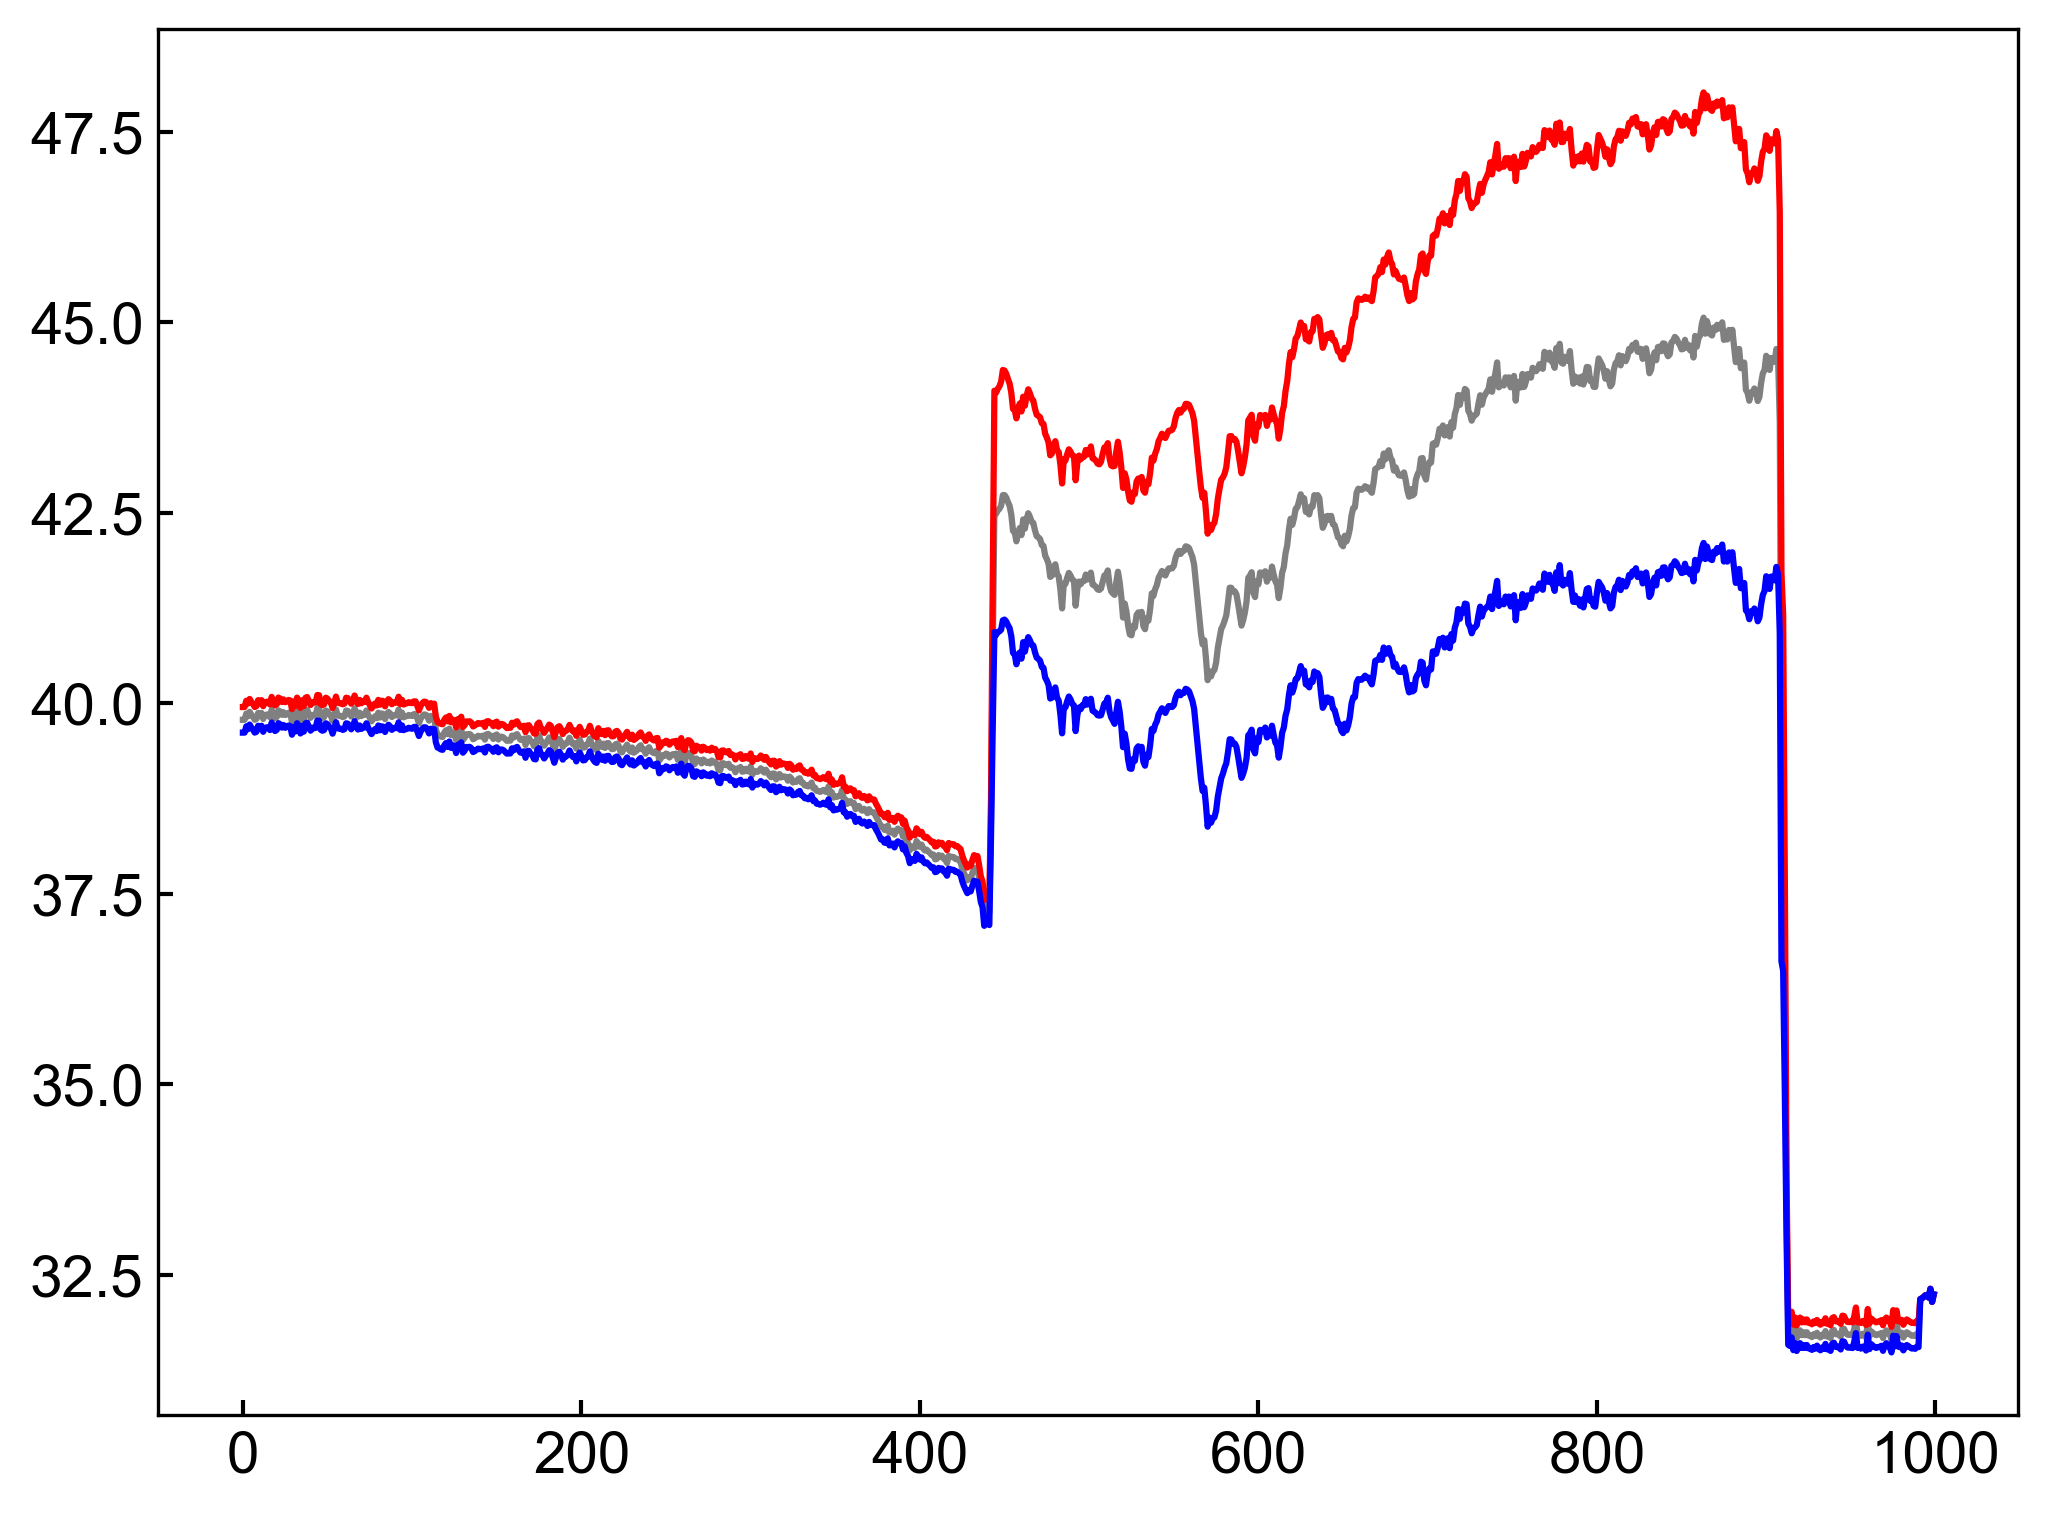

In [34]:
# 図示して確認
plt.plot(aimed_P_array['up']['values'], color='gray')
plt.plot(aimed_P_array['up']['values'] + aimed_P_array['up']['errors'], color='red')
plt.plot(aimed_P_array['up']['values'] - aimed_P_array['up']['errors'], color='blue')
plt.show()
plt.close()

# 保存

In [35]:
# 上書きするかどうかを設定
is_overwritten = selected_run_setting['is_overwritten']
is_overwritten


True

In [36]:
# 書き込み先の設定
# run_name_processed.hdfを作成する。すでにあればそれが読み込まれる
up_saved_hdf = HDF5Writer(
    file_path=os.path.join(
        selected_run_setting['save_root_path'],
        'processed_hdf',
        f'{selected_run_setting["current_run"]}_up_processed.hdf'
    )
)

down_saved_hdf = HDF5Writer(
    file_path=os.path.join(
        selected_run_setting['save_root_path'],
        'processed_hdf',
        f'{selected_run_setting["current_run"]}_down_processed.hdf'
    )
)


HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia06_2nd_up_processed.hdf
HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia06_2nd_down_processed.hdf


In [37]:
# up
up_saved_hdf.write(data_path='entry/processed/value/interpolated_T', data=interp_measured_T_dict['up']['values'], overwrite=is_overwritten)
up_saved_hdf.write(data_path='entry/processed/error/interpolated_T', data=interp_measured_T_dict['up']['errors'], overwrite=is_overwritten)
up_saved_hdf.write(data_path='entry/processed/value/P', data=aimed_P_array['up']['values'], overwrite=is_overwritten)
up_saved_hdf.write(data_path='entry/processed/error/P', data=aimed_P_array['up']['errors'], overwrite=is_overwritten)

書き込みに成功しました: 'entry/processed/value/interpolated_T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia06_2nd_up_processed.hdf
書き込みに成功しました: 'entry/processed/error/interpolated_T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia06_2nd_up_processed.hdf
書き込みに成功しました: 'entry/processed/value/P' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia06_2nd_up_processed.hdf
書き込みに成功しました: 'entry/processed/error/P' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia06_2nd_up_processed.hdf


In [38]:
# down
down_saved_hdf.write(data_path='entry/processed/value/interpolated_T', data=interp_measured_T_dict['down']['values'], overwrite=is_overwritten)
down_saved_hdf.write(data_path='entry/processed/error/interpolated_T', data=interp_measured_T_dict['down']['errors'], overwrite=is_overwritten)
down_saved_hdf.write(data_path='entry/processed/value/P', data=aimed_P_array['down']['values'], overwrite=is_overwritten)
down_saved_hdf.write(data_path='entry/processed/error/P', data=aimed_P_array['down']['errors'], overwrite=is_overwritten)


書き込みに成功しました: 'entry/processed/value/interpolated_T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia06_2nd_down_processed.hdf
書き込みに成功しました: 'entry/processed/error/interpolated_T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia06_2nd_down_processed.hdf
書き込みに成功しました: 'entry/processed/value/P' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia06_2nd_down_processed.hdf
書き込みに成功しました: 'entry/processed/error/P' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia06_2nd_down_processed.hdf
